In [ ]:
import time
import yaml
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from data import get_data
from pinn import PINN_experiment
from modules import Model
from sklearn.metrics import mean_squared_error
import torch.nn as nn #nn's layers 
import torch.optim as optim  #for optimizers

In [ ]:
with open("hyper.yml", "r") as file:
    config = yaml.safe_load(file)

activations = {
    "Tanh": nn.Tanh,
    "ReLU": nn.ReLU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid
}
optimizers = {
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop,
    "Adagrad": optim.Adagrad,
    "LBFGS": optim.LBFGS
}

def modify_network(layers, neurons, activation):
    network = [nn.Linear(2, neurons).double(), activation().double()]
    for _ in range(layers - 2):
        network.append(nn.Linear(neurons, neurons).double())
        network.append(activation().double())
    network.append(nn.Linear(neurons, 1).double())
    return nn.Sequential(*network)

def run_experiment(hyperparam_name, hyperparam_values):
    results = []

    for value in hyperparam_values:  #run pinn for each list of hyperparameter
        print(f"Running PINN for {hyperparam_name} = {value}")

        data = get_data()
        start_time = time.time()

        #"initial" NN structure 
        layers = 9
        neurons = 20
        activation = activations["Tanh"]
        optimizer = optim.Adam
        noise = 0.0
        split = 0.8
        iteration = 2000

    
        if hyperparam_name == "iterations":
            iteration = value
        elif hyperparam_name == "layers":
            layers = value
        elif hyperparam_name == "neurons":
            neurons = value
        elif hyperparam_name == "activation":
            activation = activations[value]
        elif hyperparam_name == "optimizer":
            optimizer = optimizers[value]
        elif hyperparam_name == "noise":
            noise = value
        elif hyperparam_name == "train_val_split":
            split = value


        Model.create_network = lambda self: modify_network(layers, neurons, activation)
        model = Model()
        model.adam_optimizer = optimizer(model.network.parameters())
        PINN_experiment(data, [noise], verbose=False, rerun=True)
        all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
        rmse = all_results[0][-1]
        run_time = time.time() - start_time
        results.append([hyperparam_name, value, rmse, run_time])
    return results

all_results = []
for param, values in config.items():
    all_results.extend(run_experiment(param, values))

np.savez("pinn_results.npz", results=np.array(all_results, dtype=object))
print("Results saved to pinn_results.npz")


Running PINN for iterations = 1000
Loaded data.
PINN test complete.
Running PINN for iterations = 2000
Loaded data.
PINN test complete.
Running PINN for iterations = 5000
Loaded data.
PINN test complete.
Running PINN for iterations = 10000
Loaded data.
PINN test complete.
Running PINN for layers = 3
Loaded data.
PINN test complete.
Running PINN for layers = 5
Loaded data.
PINN test complete.
Running PINN for layers = 10
Loaded data.
PINN test complete.
Running PINN for layers = 15
Loaded data.
PINN test complete.
Running PINN for layers = 20
Loaded data.
PINN test complete.
Running PINN for layers = 30
Loaded data.
PINN test complete.
Running PINN for layers = 40
Loaded data.
PINN test complete.
Running PINN for layers = 50
Loaded data.
PINN test complete.
Running PINN for layers = 60
Loaded data.
PINN test complete.
Running PINN for layers = 70
Loaded data.
PINN test complete.
Running PINN for layers = 80
Loaded data.
PINN test complete.
Running PINN for layers = 90
Loaded data.
PINN 

In [36]:
import numpy as np
import pandas as pd
data = np.load("pinn_results.npz", allow_pickle=True)
results = data["results"]
df_results = pd.DataFrame(results, columns=["Hyperparameter", "Value", "RMSE", "Time (s)"])
df_results["RMSE"] = df_results["RMSE"].astype(float).round(7)
df_results["Time (s)"] = df_results["Time (s)"].astype(float).round(2)
df_results = df_results[df_results["Hyperparameter"] != "train_val_split"]
updated_file_path = "pinn_results.npz"  # Name for the cleaned file
np.savez(updated_file_path, results=df_results.to_numpy())
print(df_results.to_string(index=False))  


Hyperparameter     Value     RMSE  Time (s)
    iterations      1000 0.000039    446.49
    iterations      2000 0.000074    476.80
    iterations      5000 0.000039    575.33
    iterations     10000 0.000100    569.40
        layers         3 0.001004    138.14
        layers         5 0.000049    242.75
        layers        10 0.000058    830.88
        layers        15 0.000089    964.30
        layers        20 0.001150   1103.66
        layers        30 0.003303   1481.93
        layers        40 0.377464    950.96
        layers        50 0.377464   1183.38
        layers        60 0.377464   1406.69
        layers        70 0.377464   1634.47
        layers        80 0.377464   1854.30
        layers        90 0.377464   2140.82
        layers       100 0.377464   2394.91
       neurons         5 0.000332    153.26
       neurons        10 0.000068    320.51
       neurons        20 0.000049    570.25
       neurons        30 0.000071    865.74
       neurons        40 0.00004

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7856\2621141107.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


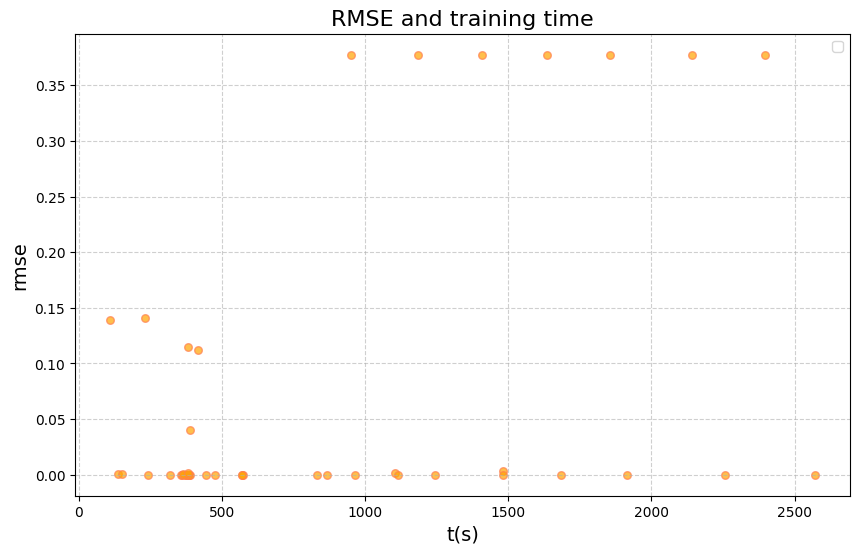

In [37]:
data = np.load("pinn_results.npz", allow_pickle=True)
results = data["results"]
df_results = pd.DataFrame(results, columns=["Hyperparameter", "Value", "RMSE", "Time (s)"])
df_results["RMSE"] = df_results["RMSE"].astype(float).round(7)
df_results["Time (s)"] = df_results["Time (s)"].astype(float).round(2)

plt.figure(figsize=(10, 6))
plt.scatter(df_results["Time (s)"], df_results["RMSE"], 
            color='orange', alpha=0.7, s=30, edgecolors='coral')
plt.xlabel("t(s)", fontsize=14)
plt.ylabel("rmse", fontsize=14)
plt.title("RMSE and training time", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


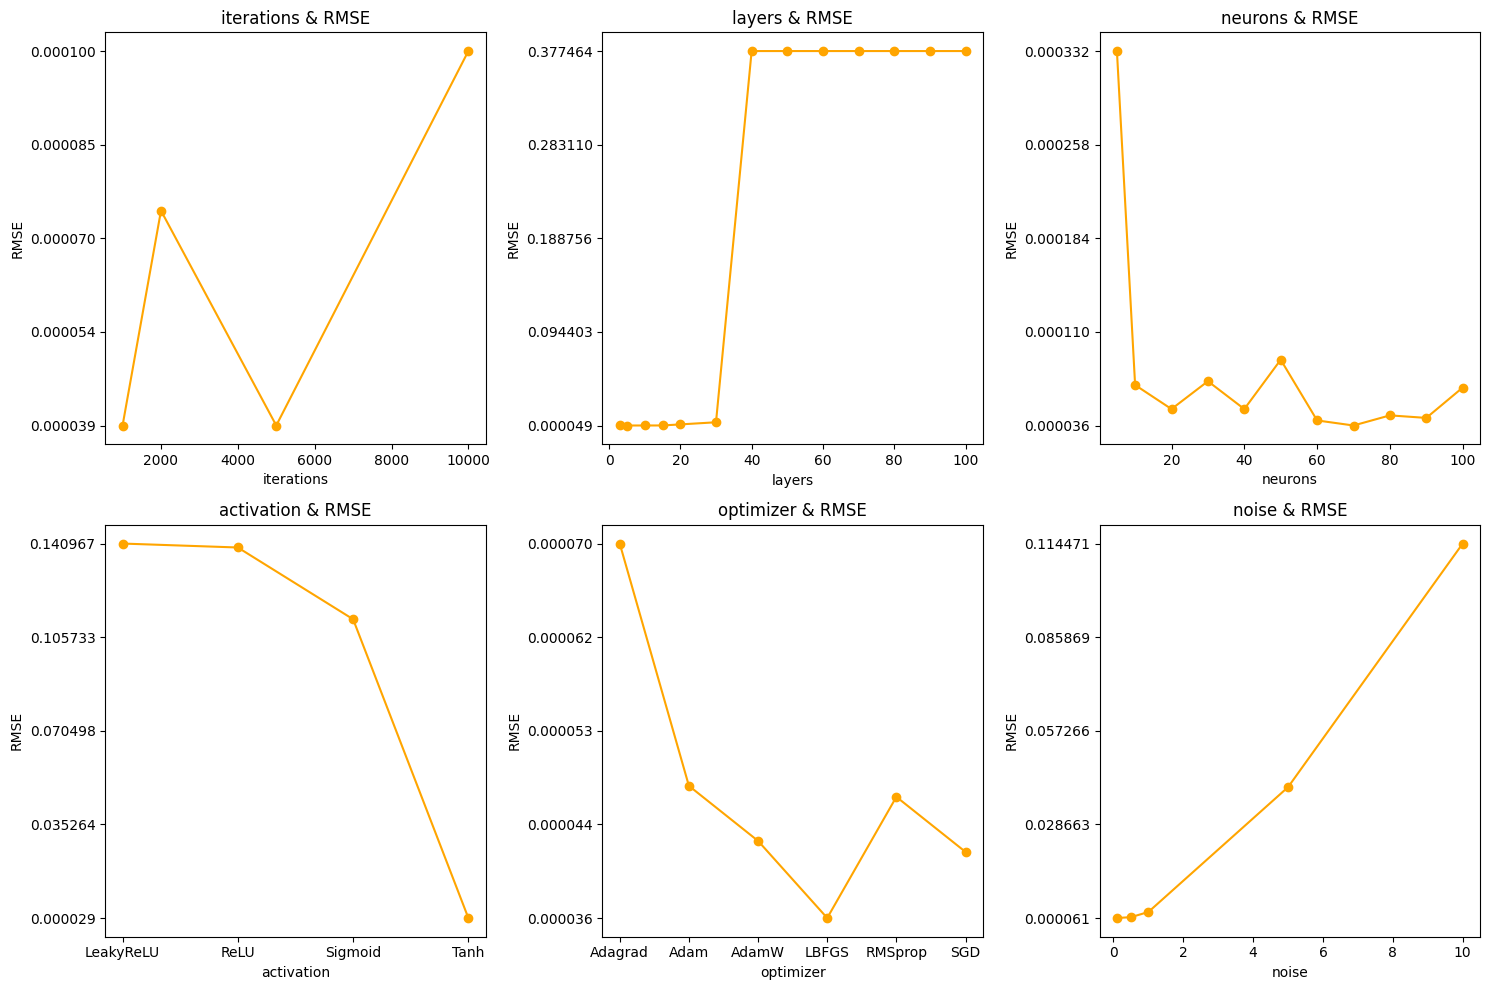

In [38]:
file_path = "pinn_results.npz"
data = np.load(file_path, allow_pickle=True)
results = data["results"]

hyperparams = {}  
for entry in results:
    param, value, rmse, run_time = entry
    if param not in hyperparams:
        hyperparams[param] = []
    hyperparams[param].append((value, round(rmse, 6))) 

num_params = len(hyperparams)
cols = 3 
rows = (num_params // cols) + (num_params % cols > 0) 
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  
for i, (param, values) in enumerate(hyperparams.items()):
    values, rmse_values = zip(*sorted(values))  
    axes[i].plot(values, rmse_values, marker="o", linestyle="-", color="orange")
    axes[i].set_title(f"{param} & RMSE")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("RMSE")
    axes[i].ticklabel_format(style='plain', axis='y')
    axes[i].set_yticks(np.linspace(min(rmse_values), max(rmse_values), num=5)) 
    axes[i].set_yticklabels([f"{y:.6f}" for y in axes[i].get_yticks()])
for j in range(i + 1, len(axes)):  #remove empty subplots
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()



 Running PINN for train_val_split = 0.6
Loaded data.
PINN test complete.
 train_val_split: 0.6 | RMSE: 0.000031 | Runtime: 225.24 sec

 Running PINN for train_val_split = 0.7
Loaded data.
PINN test complete.
 train_val_split: 0.7 | RMSE: 0.000044 | Runtime: 242.11 sec

 Running PINN for train_val_split = 0.8
Loaded data.
PINN test complete.
 train_val_split: 0.8 | RMSE: 0.000032 | Runtime: 225.08 sec

 Running PINN for train_val_split = 0.9
Loaded data.
PINN test complete.
 train_val_split: 0.9 | RMSE: 0.000036 | Runtime: 232.74 sec


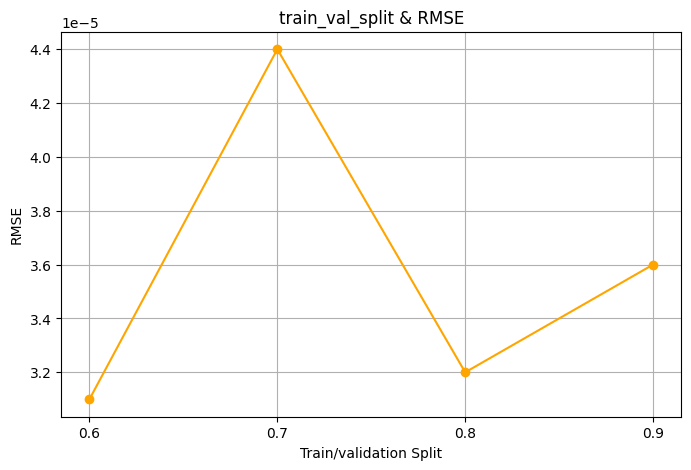

In [ ]:
from data import get_data as original_get_data  #import original get_data()

train_val_splits = [0.6, 0.7, 0.8, 0.9]
results = []

def get_data(train_val_split=0.8):
    all_data = original_get_data() 
    
    if len(all_data) == 12:
        x_test, y_test, x_train, y_train, x_bc, y_bc, x_ic, y_ic, x_val, y_val, pde_x, random_indices = all_data
    else:
        raise ValueError(f"Unexpected number of elements in all_data: {len(all_data)}")

    split_index = int(len(x_train) * train_val_split)
    x_train, y_train = x_train[:split_index], y_train[:split_index] 
    return x_test, y_test, x_train, y_train, x_bc, y_bc, x_ic, y_ic, x_val, y_val, pde_x, random_indices

for split in train_val_splits:
    print(f"\n Running PINN for train_val_split = {split}")
    data = get_data(train_val_split=split)

    start_time = time.time()
    PINN_experiment(data, noise=[0], verbose=False, rerun=True)
    all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
    rmse = round(all_results[0][-1], 6)  
    run_time = time.time() - start_time
    results.append((split, rmse, run_time))

    # Print results
    print(f" train_val_split: {split} | RMSE: {rmse:.6f} | Runtime: {run_time:.2f} sec")


plt.figure(figsize=(8, 5))
splits, rmse_values, _ = zip(*results)  
plt.plot(splits, rmse_values, marker="o", linestyle="-", color="orange")
plt.xlabel("Train/validation Split")
plt.ylabel("RMSE")
plt.title("train_val_split & RMSE")
plt.xticks(train_val_splits)
plt.grid()
plt.show()
